In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scienceplots
plt.style.use('science')
import spin_models as spin
import Merger_rate_plot as merg
import scipy.stats as st
from astropy.cosmology import WMAP9 as cosmo
from astropy.cosmology import z_at_value
from astropy import constants as const
from astropy import units as u

In [16]:
def find_q(M1,M2):
    if (M2>M1):
        q = M1/M2
    else:
        q = M2/M1
    
    return q


In [17]:
mean = 2.87678065
stdev = 0.31454837

def trip_log_v():
    return st.norm.rvs(mean,stdev)

def v_scaled(m3,qout):

    q_HL = 1/10
    m3_HL = 10**7
    v_HL = trip_log_v()

    return (np.sqrt((m3_HL*(1+q_HL))/(m3*(1+qout))) * 10**(v_HL))



In [18]:
df_binary = pd.read_csv("Data/binary-merger-data.csv",index_col= False)
df_binary.head()
df_iso_bbh = df_binary[(df_binary["Type"] == "iso") & (df_binary["Merger"] == "Yes")]

In [19]:
df_trip = pd.read_csv("Data/triples-data-with-flags.csv",index_col= False)
df_t_slingshot = df_trip[(df_trip["Flag"] == "Tr-ej") | (df_trip["Flag"] == "No")]
df_t_GW_kick = df_trip[(df_trip["Flag"] == "Tr-ej") | (df_trip["Flag"] == "Tr")]

In [20]:
N_bbh = len(df_iso_bbh["M1"])

In [88]:
Vesc = 600

In [89]:
esc_prob_slingshot = []

for j in range(1000):
    slingshot_kicks = []
    for i in range(np.shape(df_t_slingshot)[0]):
        m1 = df_t_slingshot["Mass 1"].iloc[i]
        m2 = df_t_slingshot ["Mass 2"].iloc[i]
        m3 = df_t_slingshot ["Mass 3"].iloc[i]
        m_sort = np.sort([m1,m2,m3])

        m3 = m_sort[0]
        qout = m_sort[0]/(m_sort[1]+m_sort[2])
        slingshot_kicks.append(v_scaled(m3,qout))
    
    esc_prob_slingshot.append(sum(i > Vesc for i in slingshot_kicks)/len(slingshot_kicks) * 100)

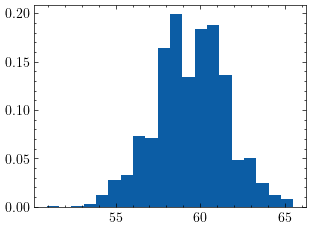

In [90]:
plt.hist(esc_prob_slingshot,bins=20,density=True)
plt.show()

In [97]:
esc_prob_GW_random = []
esc_prob_GW_aligned = []

for i in range(100):
    vGW_random = []
    vGW_aligned = []

    for i in range(np.shape(df_t_GW_kick)[0]):
        m1 = df_t_GW_kick["Mass 1"].iloc[i]
        m2 = df_t_GW_kick["Mass 2"].iloc[i]
        m3 = df_t_GW_kick["Mass 3"].iloc[i]
        m_sort = np.sort([m1,m2,m3])

        m1 = m_sort[1]
        m2 = m_sort[2]
        q = find_q(m1,m2)

        #random-dry
        S1,S2 = spin.random_dry()
        vGW_random.append(np.linalg.norm(spin.gw_kick(q,S1,S2)))

        #aligned-5deg
        S1,S2 = spin.deg5_high()
        vGW_aligned.append(np.linalg.norm(spin.gw_kick(q,S1,S2)))

    for i in range(N_bbh):
        q_i = find_q(df_iso_bbh["M1"].iloc[i],df_iso_bbh["M2"].iloc[i])

        S1,S2 = spin.random_dry()
        vGW_random.append(np.linalg.norm(spin.gw_kick(q_i,S1,S2)))

        S1,S2 = spin.deg5_high()
        vGW_aligned.append(np.linalg.norm(spin.gw_kick(q_i,S1,S2)))
    
    esc_prob_GW_aligned.append(sum(i > Vesc for i in vGW_aligned)/len(vGW_aligned) * 100)
    esc_prob_GW_random.append(sum(i > Vesc for i in vGW_random)/len(vGW_random) * 100)

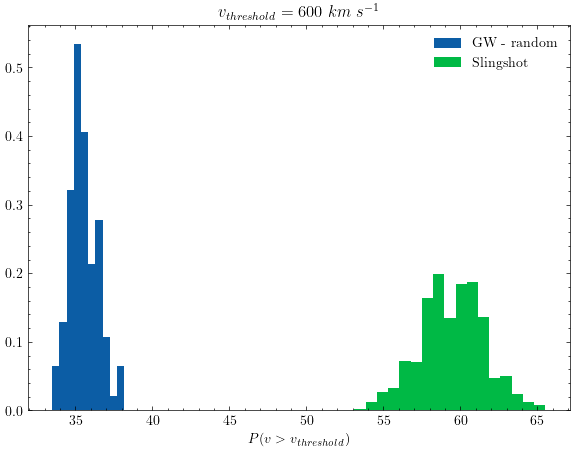

In [104]:
plt.figure(figsize=[7,5])
plt.hist(esc_prob_GW_random,density=True,label="GW - random")
plt.hist(esc_prob_slingshot,bins=20,density=True,label="Slingshot")
plt.title("$v_{threshold} = 600 \ km \ s^{-1}$")
plt.legend()
plt.xlabel("$P(v > v_{threshold})$")
plt.show()